# GTZAN_3_DecisionTreeClassifier
---

In [1]:
import numpy as np
import pandas as pd
import librosa
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

# Read in file

In [2]:
# read in file
filepath = '../gtzan/own_csv/df_noduplicates.csv'
df_3 = pd.read_csv(filepath, index_col=0)

# drop columns: 'filename', 'length' 
df_3.drop(columns=['filename', 'length'], inplace=True)

print(df_3.shape)
df_3.head(3)

(9847, 58)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues


# Set target, predictors, standardization

In [3]:
# set target and features
X = df_3.copy()
y = X.pop('label')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# standardscaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# Baseline
y_test.value_counts(normalize=True)

jazz         0.101523
classical    0.101523
blues        0.101523
country      0.101015
disco        0.100508
rock         0.100508
reggae       0.100000
hiphop       0.099492
pop          0.099492
metal        0.094416
Name: label, dtype: float64

### PCA (all features)
---

In [4]:
# PCA (n_components: 0.9999)
n_components = 0.9999
pca = PCA(n_components=n_components, random_state=1, svd_solver='full')
X_train_pc = pd.DataFrame(pca.fit_transform(X_train), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_train.index)

X_test_pc = pd.DataFrame(pca.transform(X_test), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_test.index)

display(X_train_pc.head(3))
print(pca.explained_variance_ratio_.cumsum())

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_47,PC_48,PC_49,PC_50,PC_51,PC_52,PC_53,PC_54,PC_55,PC_56
6535,-5.273166,-6.167187,1.345471,1.123555,-0.603370,0.771625,0.755719,-1.004752,-0.159771,-0.063493,...,0.121074,-0.019945,0.445561,0.271364,-0.479309,-0.523248,0.187016,0.103133,-0.100394,0.014560
625,-0.515342,1.813487,4.630386,1.915605,1.681363,0.436591,-2.147151,-0.577363,-0.365986,-0.371310,...,0.064622,0.632422,0.140321,0.062738,0.381988,0.037552,-0.210541,-0.120403,-0.048747,-0.000290
1949,-1.794878,2.274721,3.316637,3.989158,-2.708549,1.932897,3.609233,2.383106,-3.494039,4.396239,...,0.203891,0.191172,-0.026600,0.886325,0.137341,-0.311034,0.018842,-0.080876,-0.192847,-0.346759


[0.19693593 0.33277709 0.43657312 0.50294066 0.54678617 0.58377001
 0.61335998 0.64023907 0.6654956  0.68693547 0.70569705 0.72351818
 0.74058495 0.75561978 0.76921124 0.78091766 0.79207139 0.8028624
 0.81266499 0.82197806 0.8307666  0.8393097  0.84764316 0.85579663
 0.86365234 0.8712389  0.8787581  0.88603821 0.89305122 0.89996235
 0.90665321 0.91317655 0.91945846 0.92558516 0.93161825 0.93740046
 0.94281321 0.94806709 0.95306707 0.95768618 0.96227398 0.96674103
 0.97104055 0.97518641 0.97913969 0.98283504 0.9863513  0.98951242
 0.99244916 0.99497769 0.99679816 0.99807571 0.99902133 0.99959884
 0.99980932 0.99994241]


# DTC (original features)
---

In [5]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
dtc.score(X_train, y_train)

print('train score:\t', dtc.score(X_train, y_train))
print('test score:\t', dtc.score(X_test, y_test))
print('cv mean:\t', cross_val_score(dtc, X_train, y_train, cv=5).mean())

train score:	 1.0
test score:	 0.6609137055837564
cv mean:	 0.622698976714205


In [73]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=1, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

0.17455884219880666
0.1744317138022722
0.1766497461928934


In [7]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=2, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

0.24438237907832933
0.24298598017887357
0.24720812182741117


In [8]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=5, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

0.45499555668401676
0.43595407299975825
0.433502538071066


In [9]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=10, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

0.7402564428081757
0.6003548465071308
0.6035532994923858


In [10]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=20, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

0.9965722990986416
0.6235873015873016
0.6588832487309645


In [11]:
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=50, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

1.0
0.6233334139070179
0.6527918781725889


In [12]:
classifier = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=None, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_train, y_train))
print(cross_val_score(classifier, X_train, y_train, cv=5).mean())
print(classifier.score(X_test, y_test))

1.0
0.6233334139070179
0.6527918781725889


In [74]:
# function for scores dataframe (dtc)
def dtc_scores(data_train=X_train_pc, data_test=X_test_pc, 
               depth_min=1, depth_max=20, depth_increment=1):
    """
    fit and score for a range of depths (dtc)
    """
    depth_range = range(depth_min, depth_max+1, depth_increment)
    train_scores_list = []
    test_scores_list = []
    cv_means_list = []
    error_rate = []

    for depth in depth_range:
        dtc = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=1)
        dtc.fit(data_train, y_train)

        train_scores_list.append(dtc.score(data_train, y_train))
        test_scores_list.append(dtc.score(data_test, y_test))
        cv_means_list.append(cross_val_score(dtc, data_train, y_train, cv=5).mean())
        
        pred_test = dtc.predict(data_test)
        error_rate.append((pred_test != y_test).mean())

    df_dtc_scores = pd.DataFrame({'max_depth':depth_range, 
                                 'train_scores':train_scores_list,
                                 'test_scores':test_scores_list,
                                 'cv_means':cv_means_list, 
                                 'error_rate':error_rate})

    df_dtc_scores.set_index('max_depth', inplace=True)

    # return cv_means_max, error_rate_min (and corresponding k (num of neighbors)), on condition of k > 1
#     if neighbors_min > 1:
    cv_means_max = df_dtc_scores.cv_means.max()
    cv_means_max_depth = df_dtc_scores[df_dtc_scores.cv_means == df_dtc_scores.cv_means.max()].index[0]
    error_rate_min = df_dtc_scores.error_rate.min()
    error_rate_min_depth = df_dtc_scores[df_dtc_scores.error_rate == df_dtc_scores.error_rate.min()].index[0]
#     else:
#         cv_means_max = df_knn_scores.iloc[1:].cv_means.max()
#         cv_means_max_neighbors = df_knn_scores.iloc[1:][df_knn_scores.iloc[1:].cv_means == df_knn_scores.iloc[1:].cv_means.max()].index[0]
#         error_rate_min = df_knn_scores.iloc[1:].error_rate.min()
#         error_rate_min_neighbors = df_knn_scores.iloc[1:][df_knn_scores.iloc[1:].error_rate == df_knn_scores.iloc[1:].error_rate.min()].index[0]
                        
    print(f'CV means max:\t{cv_means_max}\tDepth: {cv_means_max_depth}')
    print(f'Error rate min:\t{error_rate_min}\tDepth: {cv_means_max_depth}')

    return df_dtc_scores

In [75]:
# function to plot scores for varying depths (dtc)
def dtc_scores_plot(df):
    """
    plot scores for range of depths
    """
    cv_means_max = df.cv_means.max()
    cv_means_max_depth = df[df.cv_means == df.cv_means.max()].index[0]
    
    df = df.iloc[:,:-1] #exclude error rate from scale
    df.plot(figsize=(14,8))
    plt.vlines(x=cv_means_max_depth, 
               ymin=df.min().min(), ymax=df.max().max(), 
               colors='k', linestyles='dashed', lw=0.5, label='', data=None)
    plt.legend(loc = 'best')
    plt.xticks(range(df.index[0], df.index[-1], int((df.index[-1] - df.index[0]) / 20)+1))
    plt.title('Scores at different depths (DTC)')
    plt.xlabel('depth')
    plt.ylabel('accuracy score');
    
    print(f'CV means max: {cv_means_max}\nDepth: {cv_means_max_depth}')

In [14]:
df_dtc_scores = dtc_scores(data_train=X_train, data_test=X_test, 
                           depth_min=1, depth_max=50, depth_increment=1)
df_dtc_scores

CV means max:	0.6370443961002337	Depth: 14
Error rate min:	0.3350253807106599	Depth: 14


,train_scores,test_scores,cv_means,error_rate
max_depth,,,,
1,0.174559,0.176650,0.174432,0.823350
2,0.244382,0.247208,0.242986,0.752792
3,0.314587,0.319797,0.305447,0.680203
4,0.397613,0.388325,0.385934,0.611675
5,0.454996,0.433503,0.435954,0.566497
6,0.528501,0.497462,0.496382,0.502538
7,0.580297,0.523858,0.531294,0.476142
8,0.629174,0.558376,0.555287,0.441624
9,0.683001,0.582741,0.581694,0.417259


CV means max: 0.6370443961002337
Depth: 14


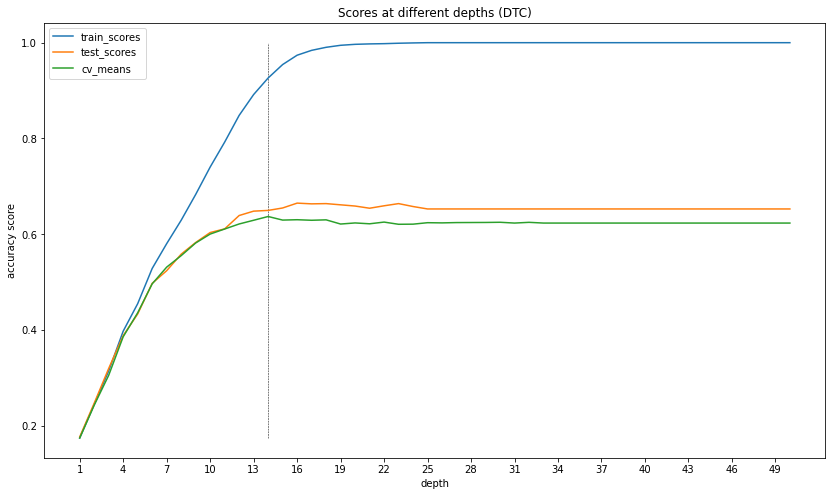

In [16]:
dtc_scores_plot(df_dtc_scores)

# DTC (PC features)
---

In [18]:
df_dtc_scores = dtc_scores(data_train=X_train_pc, data_test=X_test_pc, 
                           depth_min=1, depth_max=50, depth_increment=1)
df_dtc_scores

CV means max:	0.5626524856981711	Depth: 20
Error rate min:	0.4294416243654822	Depth: 20


,train_scores,test_scores,cv_means,error_rate
max_depth,,,,
1,0.183826,0.185279,0.183573,0.814721
2,0.277009,0.276650,0.276249,0.723350
3,0.355338,0.336041,0.350136,0.663959
4,0.404215,0.402538,0.392409,0.597462
5,0.459058,0.439086,0.429224,0.560914
6,0.503999,0.448731,0.460329,0.551269
7,0.569887,0.482234,0.500827,0.517766
8,0.632474,0.517259,0.516949,0.482741
9,0.698870,0.539594,0.535738,0.460406


CV means max: 0.5626524856981711
Depth: 20


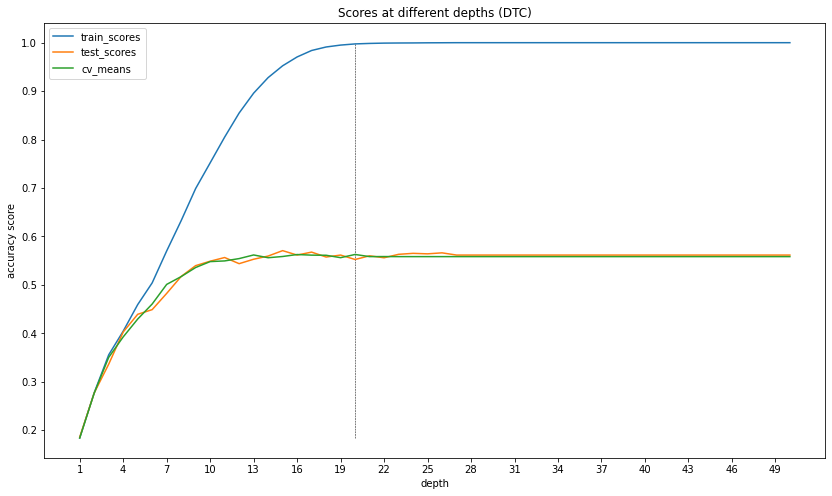

In [19]:
dtc_scores_plot(df_dtc_scores)

# GridSearchCV (original features)

In [108]:
dtc = DecisionTreeClassifier()

param_grid = {'criterion':['gini', 'entropy'], 
             'splitter':['best', 'random'], 
             'max_depth':[3,13,14,15, None], 
             'random_state':[1], 
             'class_weight':['balanced']}

grid = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-2)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    8.0s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-2,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 13, 14, 15, None],
                         'random_state': [1], 'splitter': ['best', 'random']},
             verbose=1)

In [109]:
print('grid best estimator:\t', grid.best_estimator_)
print('grid best params:\t', grid.best_params_)
print('grid cv mean:\t\t', grid.best_score_)
print('grid train score:\t', grid.score(X_train, y_train))
print('grid test score:\t', grid.score(X_test, y_test))

grid best estimator:	 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, random_state=1)
grid best params:	 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 14, 'random_state': 1, 'splitter': 'best'}
grid cv mean:		 0.6521479332849891
grid train score:	 0.9838771105750921
grid test score:	 0.6558375634517767


In [7]:
dtc = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', 
                             max_depth=14, random_state=1, splitter='best')

dtc.fit(X_train, y_train)

print('train score:\t', dtc.score(X_train, y_train))
print('test score:\t', dtc.score(X_test, y_test))
print('cv mean:\t', cross_val_score(dtc, X_train, y_train, cv=5).mean())

train score:	 0.9838771105750921
test score:	 0.6558375634517767
cv mean:	 0.6521479332849891


# GridSearchCV (PC features)

In [53]:
grid.fit(X_train_pc, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    7.6s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 13, 14, 15, None],
                         'random_state': [1], 'splitter': ['best', 'random']},
             verbose=1)

In [55]:
print('grid best estimator:\t', grid.best_estimator_)
print('grid best params:\t', grid.best_params_)
print('grid cv mean:\t\t', grid.best_score_)
print('grid train score:\t', grid.score(X_train_pc, y_train))
print('grid test score:\t', grid.score(X_test_pc, y_test))

grid best estimator:	 DecisionTreeClassifier(criterion='entropy', random_state=1)
grid best params:	 {'criterion': 'entropy', 'max_depth': None, 'random_state': 1, 'splitter': 'best'}
grid cv mean:		 0.5673454999597132
grid train score:	 1.0
grid test score:	 0.5903553299492386


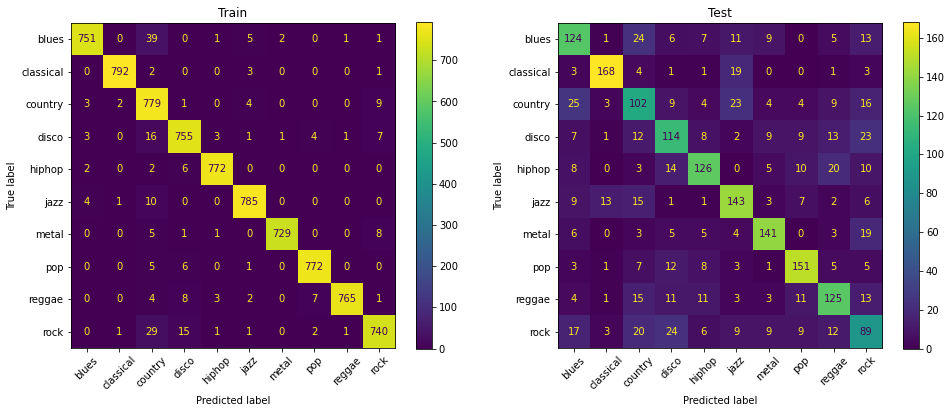

In [58]:
# Grid (original features)
# confusion matrix
pred_train = grid.predict(X_train)
pred_test = grid.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(grid, X_train, y_train, ax=ax[0], xticks_rotation=45)
plot_confusion_matrix(grid, X_test, y_test, ax=ax[1], xticks_rotation=45)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [59]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     0.9843    0.9387    0.9610       800
   classical     0.9950    0.9925    0.9937       798
     country     0.8743    0.9762    0.9224       798
       disco     0.9533    0.9545    0.9539       791
      hiphop     0.9885    0.9872    0.9878       782
        jazz     0.9788    0.9812    0.9800       800
       metal     0.9959    0.9798    0.9878       744
         pop     0.9834    0.9847    0.9841       784
      reggae     0.9961    0.9684    0.9820       790
        rock     0.9648    0.9367    0.9505       790

    accuracy                         0.9699      7877
   macro avg     0.9714    0.9700    0.9703      7877
weighted avg     0.9712    0.9699    0.9702      7877


Classification report: test set

              precision    recall  f1-score   support

       blues     0.6019    0.6200    0.6108       200
   classical     0.8796    0.8400    0.8593       200
     coun

# Bagging Classifier

In [76]:
from sklearn.ensemble import BaggingClassifier

In [77]:
dtc = DecisionTreeClassifier(criterion='gini',
    splitter='best',
    max_depth=None,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features=None,
    random_state=1)

In [ ]:
#grid best params:	 {'criterion': 'entropy', 'max_depth': 13, 'random_state': 1, 'splitter': 'best'}

In [82]:
# max samples larger
# features: less 0.3 for rfc?
# bootstrapping. even if max samples =1 and max features =1, wouldn't be redundant... always random..?

# try:
# rfc: max samples 1, max features 0.3
# dtc: max samples 1, max features 1


bc_dtc = BaggingClassifier(base_estimator=dtc, n_estimators=100, 
                                  max_samples=1.0, max_features=1.0, random_state=1, verbose=1)
bc_dtc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.1s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                  n_estimators=100, random_state=1, verbose=1)

In [83]:
print('Train score:', bc_dtc.score(X_train, y_train))
print('CV mean:', cross_val_score(bc_dtc, X_train, y_train, cv=5).mean())
print('Test score:', bc_dtc.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train score: 1.0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.3s finished
[Parallel(n_jobs=1)]: Us

CV mean: 0.8338194343727338
Test score: 0.8345177664974619


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


# GridSearch Bagging

In [ ]:
dtc = DecisionTreeClassifier(criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight='balanced',
    presort='deprecated',
    ccp_alpha=0.0)


bagging = BaggingClassifier(base_estimator=)

In [23]:
from sklearn.model_selection import GridSearchCV

In [25]:
dtc.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1,
 'splitter': 'best'}

In [38]:
dtc_param = {'ccp_alpha': [0.0],
 'class_weight': [None],
 'criterion': ['gini'],
 'max_depth': range(1,52,5),
 'max_features': np.linspace(0.1,1.0,10),
#  'max_leaf_nodes': None,
#  'min_impurity_decrease': 0.0,
#  'min_impurity_split': None,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'presort': 'deprecated',
 'random_state': [1],
 'splitter': ['best']}

grid = GridSearchCV(estimator=dtc, param_grid=dtc_param, n_jobs=2, verbose=1, return_train_score=True)
grid.fit(X_train_pc, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 128 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:   48.7s finished


GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=2,
             param_grid={'ccp_alpha': [0.0], 'class_weight': [None],
                         'criterion': ['gini'], 'max_depth': range(1, 52, 5),
                         'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'random_state': [1], 'splitter': ['best']},
             return_train_score=True, verbose=1)

In [39]:
grid.best_params_

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 0.7000000000000001,
 'random_state': 1,
 'splitter': 'best'}

In [40]:
print('Train score:', grid.score(X_train_pc, y_train))
print('CV mean:', cross_val_score(grid, X_train_pc, y_train, cv=5).mean())
print('Test score:', grid.score(X_test_pc, y_test))

Train score: 0.998998998998999
Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 202 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 488 tasks      | elapsed:   32.0s
[Parallel(n_jobs=2)]: Done 547 out of 550 | elapsed:   36.9s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:   37.2s finished


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 230 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done 498 tasks      | elapsed:   31.7s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:   35.6s finished


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 230 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done 498 tasks      | elapsed:   31.2s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:   35.0s finished


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 230 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done 500 tasks      | elapsed:   30.8s
[Parallel(n_jobs=2)]: Done 547 out of 550 | elapsed:   34.3s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:   34.5s finished


Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 230 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done 498 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done 550 out of 550 | elapsed:   34.0s finished


CV mean: 0.5513041239009675
Test score: 0.5635635635635635


In [42]:
param_grid = {
    'base_estimator__max_depth' : range(1,52,5),
    'max_samples' : [0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 
    'max_features': np.linspace(0.1,1.0,10)
}

clf = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                   param_grid, scoring='accuracy', verbose=1, n_jobs=2)
clf.fit(X_train_pc, y_train)

Fitting 5 folds for each of 660 candidates, totalling 3300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   46.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 23.8min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 39.2min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 57.4min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 77.8min
[Parallel(n_jobs=2)]: Done 3300 out of 3300 | elapsed: 82.6min finished


GridSearchCV(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         max_features=0.5, n_estimators=100),
             n_jobs=2,
             param_grid={'base_estimator__max_depth': range(1, 52, 5),
                         'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_samples': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]},
             scoring='accuracy', verbose=1)

In [50]:
# pickle model
filename = 'bagging_gs.sav'
pickle.dump(clf, open(filename, 'wb'))

In [56]:
# load the model from disk
filename = 'bagging_gs.sav'
clf = pickle.load(open(filename, 'rb'))

print('Train score:', clf.score(X_train_pc, y_train))
print('CV mean:', cross_val_score(clf, X_train_pc, y_train, cv=5).mean())
print('Test score:', clf.score(X_test_pc, y_test))

Train score: 0.9984984984984985
Fitting 5 folds for each of 660 candidates, totalling 3300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s


KeyboardInterrupt: 

In [43]:
clf.best_params_

{'base_estimator__max_depth': 16, 'max_features': 0.5, 'max_samples': 0.5}

In [49]:
print('Train score:', clf.score(X_train_pc, y_train))
# print('CV mean:', cross_val_score(clf, X_train_pc, y_train, cv=5).mean())
print('Test score:', clf.score(X_test_pc, y_test))

Train score: 0.9984984984984985
Test score: 0.7717717717717718


In [45]:
model = BaggingClassifier(max_features=clf.best_params_[1], max_samples=clf.best_params_[2])
model.fit(X_train_pc, y_train)

print('Train score:', model.score(X_train_pc, y_train))
print('CV mean:', cross_val_score(model, X_train_pc, y_train, cv=5).mean())
print('Test score:', model.score(X_test_pc, y_test))

KeyError: 1